In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d
from skimage import morphology, transform
import networkx as nx
import cv2

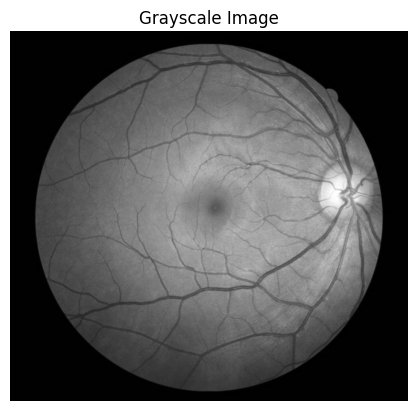

Max Intensity:  247
Min Intensity:  0


In [30]:
# Load the retinal fundus image in grayscale
image_path = 'Fundus.jpeg'
img = cv2.imread(image_path)
if img is None:
    raise IOError("Image not found. Check the image path.")

# Convert to RGB (OpenCV loads images in BGR format by default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()
print("Max Intensity: ",np.max(gray_img))
print("Min Intensity: ",np.min(gray_img))

In [31]:
# Create a CLAHE object for comparison
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gray_img)
# Apply median filter with 5x5 kernel
clahe_img = cv2.medianBlur(clahe_img, 5)

In [32]:
def perona_malik_diffusion(img, num_iterations=10, kappa=20, gamma=0.1):
    """
    Perform Perona–Malik anisotropic diffusion on a 2D grayscale image.

    Parameters
    ----------
    img            : 2D numpy array (grayscale image)
    num_iterations : int, number of diffusion iterations
    kappa          : float, edge threshold parameter
    gamma          : float, time-step size (should be <= 0.25 for stability in 2D)

    Returns
    -------
    diffused : 2D numpy array, the filtered image
    """

    # Convert to float32 for numerical stability.
    diffused = img.astype(np.float32)

    for _ in range(num_iterations):
        # Compute finite differences (gradients) in the four directions:
        # North gradient (top neighbor)
        gradN = np.roll(diffused,  1, axis=0) - diffused
        # South gradient (bottom neighbor)
        gradS = np.roll(diffused, -1, axis=0) - diffused
        # East gradient (right neighbor)
        gradE = np.roll(diffused, -1, axis=1) - diffused
        # West gradient (left neighbor)
        gradW = np.roll(diffused,  1, axis=1) - diffused

        # Perona–Malik conduction coefficients in each direction.
        # conduction function: c = exp( - (|gradI| / kappa)^2 )
        cN = np.exp(-(gradN/kappa)**2)
        cS = np.exp(-(gradS/kappa)**2)
        cE = np.exp(-(gradE/kappa)**2)
        cW = np.exp(-(gradW/kappa)**2)

        # Update the image by discrete PDE:
        diffused += gamma * (
            cN * gradN + cS * gradS +
            cE * gradE + cW * gradW
        )

    return diffused

In [33]:
niter = 10  # Too few iterations might not remove enough noise; too many can over-smooth or produce artifacts (especially if gamma is large)
kappa = 60  # If you see too much blurring at vessel edges, lower kappa. If you see little noise reduction, increase kappa.
gamma = 0.1  # If you see “ringing” or instability, lower gamma. If you want the same smoothing in fewer iterations, you can raise gamma

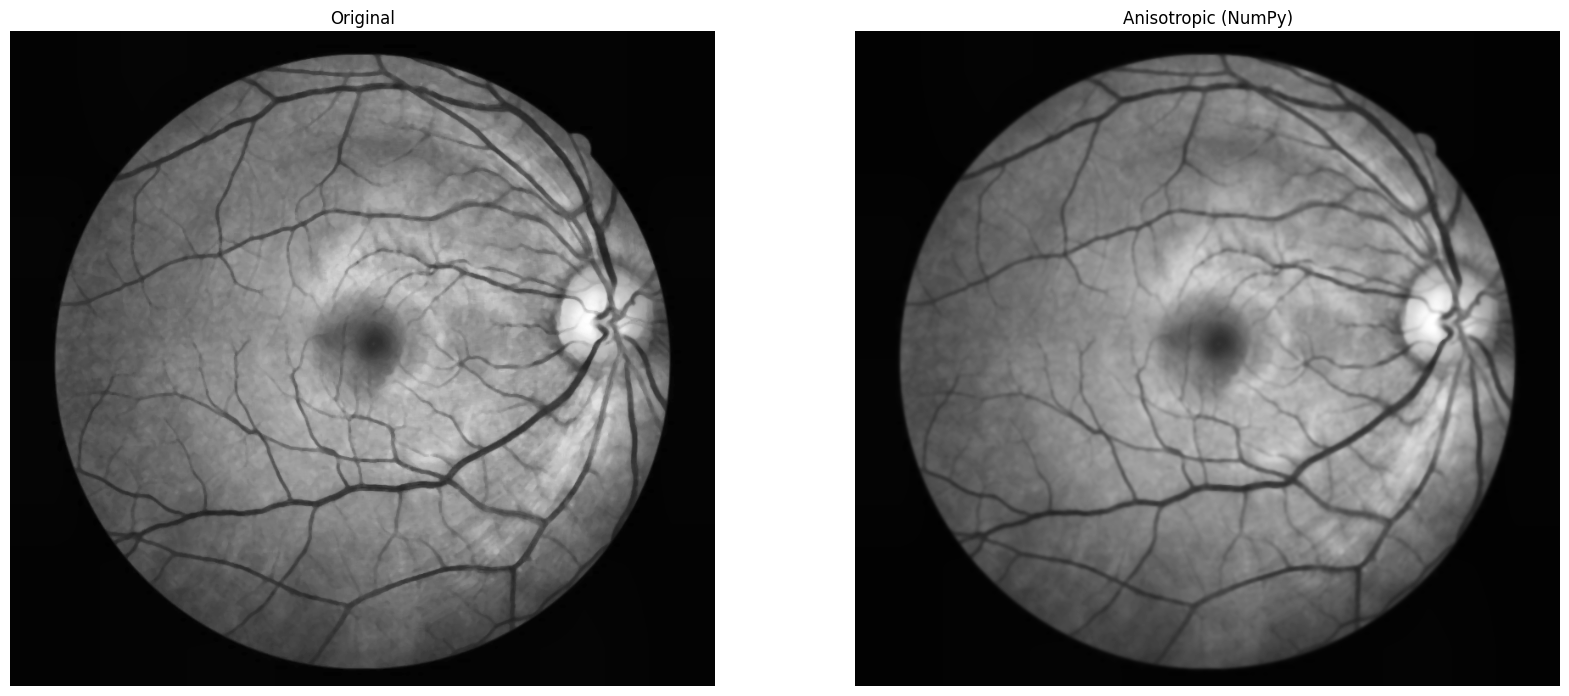

In [34]:
# Apply our pure NumPy Perona–Malik filter
filtered_np = perona_malik_diffusion(clahe_img,
                                     num_iterations=niter,
                                     kappa=kappa,
                                     gamma=gamma)
# Compare original and filtered
plt.figure(figsize=(20,15))
plt.subplot(1,2,1); plt.imshow(clahe_img, cmap='gray'); plt.title('Original'); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(filtered_np, cmap='gray'); plt.title("Anisotropic (NumPy)"); plt.axis("off")
plt.show()

In [35]:
def manual_scharr_all_kernels(gray_img):
    # 3x3 Scharr for first derivative in x
    kx_3x3 = (1.0 / 32) * np.array([
        [-3,  0,  3],
        [-10, 0, 10],
        [ -3,  0,  3]
    ], dtype=np.float64)

    # 3x3 Scharr for first derivative in y
    ky_3x3 = (1.0 / 32) * np.array([
                   [-3, -10, -3],
                   [ 0,   0,  0],
                   [ 3,  10,  3]], dtype=np.float64)

    # 5x5 Scharr for second derivative in x
    kxx_5x5 = (1.0 / 1024) * np.array([
        [   9,   0,  -18,   0,    9],
        [   60,   0, -120,   0,    60],
        [ 118,   0,  -236,   0,  118],
        [   60,   0,  -120,   0,   60],
        [   9,   0,  -18,   0,    9]
    ], dtype=np.float64)

    # 5x5 Scharr for second derivative in x
    kyy_5x5 = (1.0 / 1024) * np.array([
        [   9,   60,  118,   60,    9],
        [   0,   0,   0,   0,    0],
        [ -18,   -120,  -236,   -120, -18],
        [   0,   0,  0,   0,   0],
        [   9,   60,  118,   60,    9]
    ], dtype=np.float64)

    # 5x5 Scharr for mixed partial derivative
    kxy_5x5 = (1.0 / 1024) * np.array([
        [ -9,  -30,    0,   30,    9],
        [-30, -100,    0,  100,   30],
        [  0,    0,    0,    0,    0],
        [ 30,  100,    0, -100,  -30],
        [  9,   30,    0,  -30,   -9]
    ], dtype=np.float64)

    # Convert image to float64 for safe accumulation
    img_float = gray_img.astype(np.float64)

    # -------------------------------------------------------------------------
    # 2. Convolve with each kernel
    # -------------------------------------------------------------------------
    I_kx  = convolve2d(img_float, kx_3x3,  mode='same', boundary='symm')
    I_ky = convolve2d(img_float, ky_3x3, mode='same', boundary='symm')
    I_kxx = convolve2d(img_float, kxx_5x5, mode='same', boundary='symm')
    I_kyy = convolve2d(img_float, kyy_5x5, mode='same', boundary='symm')
    I_kxy = convolve2d(img_float, kxy_5x5, mode='same', boundary='symm')

    # -------------------------------------------------------------------------
    # 3. Combine their absolute responses by taking the mean
    #    (or you could use max, sum, RMS, etc. as you prefer)
    # -------------------------------------------------------------------------
    combined_magnitude = (np.abs(I_kx) + np.abs(I_ky) + np.abs(I_kxx) + np.abs(I_kyy) + np.abs(I_kxy)) / 5.0

    # -------------------------------------------------------------------------
    # 4. For the *orientation*, you have a few choices:
    #    - You could simply continue using orientation from the first-derivative
    #      pair (kx_3x3, ky_3x3).  But here we have no "ky" in the example.
    #    - Or define orientation from (I_kx, I_kxx), etc.
    #    - Or skip orientation if you only want a scalar edge measure.
    #
    #    Below we just do something simplistic like orientation = arctan2(I_kxx, I_kx).
    #    In practice, if you want a true gradient direction you would also convolve
    #    with the Scharr-y kernel.
    # -------------------------------------------------------------------------
    orientation = np.arctan2(I_kxx, I_kx)

    return I_kx, I_ky, I_kxx, I_kyy, I_kxy, combined_magnitude, orientation

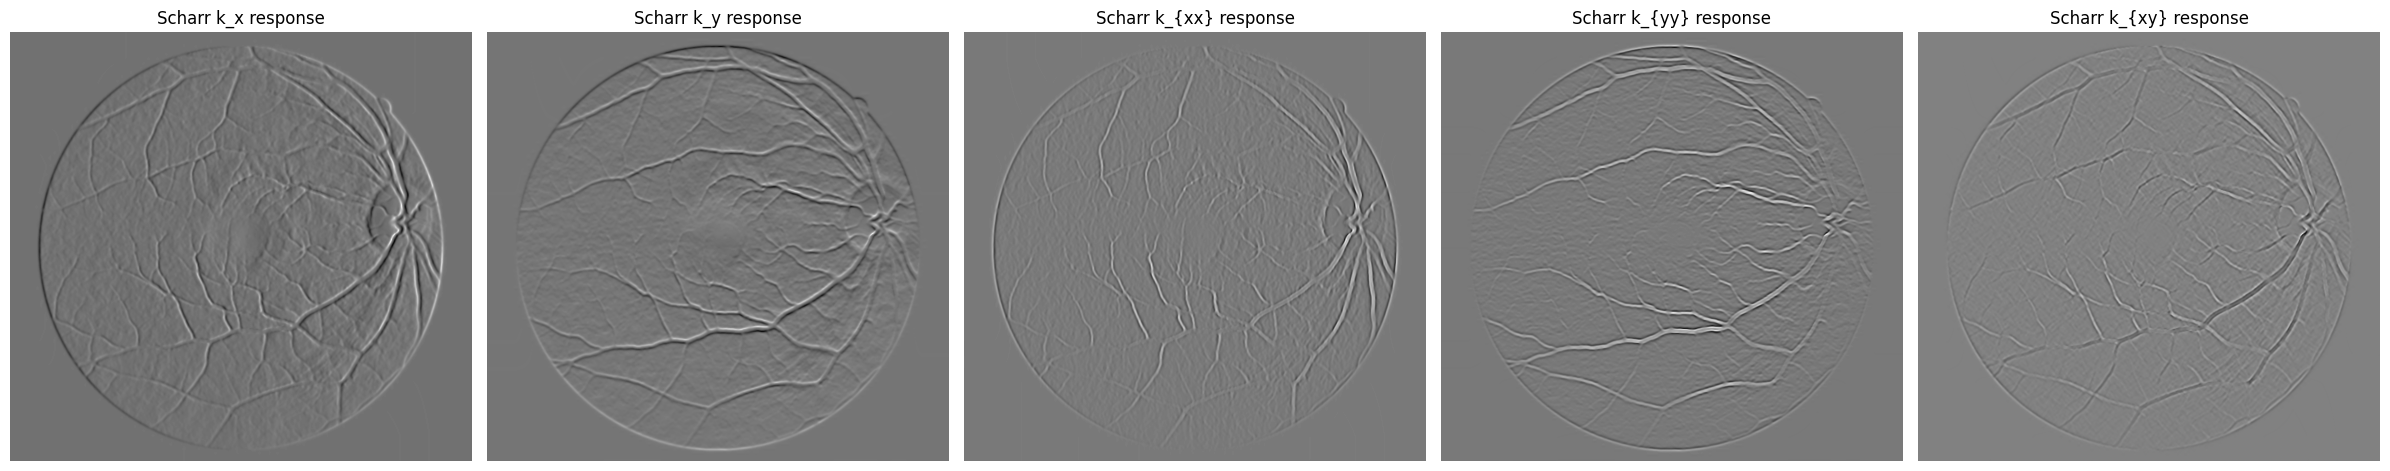

In [36]:
I_kx, I_ky, I_kxx, I_kyy, I_kxy, combined_magnitude, orientation_ = manual_scharr_all_kernels(filtered_np)

fig, axes = plt.subplots(1, 5, figsize=(24, 6))

axes[0].imshow(I_kx, cmap='gray')
axes[0].set_title('Scharr k_x response')
axes[0].axis('off')

axes[1].imshow(I_ky, cmap='gray')
axes[1].set_title('Scharr k_y response')
axes[1].axis('off')

axes[2].imshow(I_kxx, cmap='gray')
axes[2].set_title('Scharr k_{xx} response')
axes[2].axis('off')

axes[3].imshow(I_kyy, cmap='gray')
axes[3].set_title('Scharr k_{yy} response')
axes[3].axis('off')

axes[4].imshow(I_kxy, cmap='gray')
axes[4].set_title('Scharr k_{xy} response')
axes[4].axis('off')

plt.tight_layout()
plt.show()

In [37]:
def non_maximum_suppression(magnitude, orientation):
    """
    Thin edges by suppressing non-maximal values in the gradient direction.

    Parameters
    ----------
    magnitude : np.ndarray
        Gradient magnitude (same shape as orientation).
    orientation : np.ndarray
        Gradient orientation, in radians.

    Returns
    -------
    nms_result : np.ndarray
        Non-maximum suppressed gradient magnitude (thinned edges).
    """
    # Dimensions
    H, W = magnitude.shape

    # Output array initialized to zeros
    nms_result = np.zeros((H, W), dtype=np.float64)

    # Convert orientation to degrees [0, 180)
    # (We only need the "direction" part for NMS, so 0..180 is enough)
    angle_deg = np.degrees(orientation) % 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            # Current magnitude
            mag_ij = magnitude[i, j]

            # Determine gradient direction, "rounded" to one of four possibilities
            # 0°, 45°, 90°, or 135°
            region = 255  # some sentinel large number
            # We'll compare mag_ij with its neighbors along gradient direction
            if (0 <= angle_deg[i, j] < 22.5) or (157.5 <= angle_deg[i, j] < 180):
                # Approx. horizontal edge
                left_mag  = magnitude[i, j-1]
                right_mag = magnitude[i, j+1]
                if mag_ij >= left_mag and mag_ij >= right_mag:
                    nms_result[i, j] = mag_ij

            elif (22.5 <= angle_deg[i, j] < 67.5):
                # Diagonal 45°
                up_right_mag   = magnitude[i-1, j+1]
                down_left_mag  = magnitude[i+1, j-1]
                if mag_ij >= up_right_mag and mag_ij >= down_left_mag:
                    nms_result[i, j] = mag_ij

            elif (67.5 <= angle_deg[i, j] < 112.5):
                # Vertical edge ~90°
                up_mag   = magnitude[i-1, j]
                down_mag = magnitude[i+1, j]
                if mag_ij >= up_mag and mag_ij >= down_mag:
                    nms_result[i, j] = mag_ij

            elif (112.5 <= angle_deg[i, j] < 157.5):
                # Diagonal 135°
                up_left_mag    = magnitude[i-1, j-1]
                down_right_mag = magnitude[i+1, j+1]
                if mag_ij >= up_left_mag and mag_ij >= down_right_mag:
                    nms_result[i, j] = mag_ij

    return nms_result

def hysteresis_thresholding(nms_mag, low_ratio=0.1, high_ratio=0.2):
    """
    Apply hysteresis thresholding to a non-maximum suppressed magnitude image.

    Parameters
    ----------
    nms_mag : np.ndarray
        Non-maximum suppressed magnitude.
    low_ratio : float
        Fraction of the maximum magnitude to use as the low threshold.
    high_ratio : float
        Fraction of the maximum magnitude to use as the high threshold.

    Returns
    -------
    edges : np.ndarray
        Binary edge map (dtype=bool).
    """
    H, W = nms_mag.shape
    edges = np.zeros((H, W), dtype=bool)

    # Compute absolute thresholds from ratios
    high_thresh = nms_mag.max() * high_ratio
    low_thresh  = nms_mag.max() * low_ratio

    # Mark strong and weak edges
    strong_i, strong_j = np.where(nms_mag >= high_thresh)
    weak_i, weak_j   = np.where((nms_mag <= high_thresh) & (nms_mag >= low_thresh))

    # Result array to fill:
    # 0 = not an edge, 1 = weak edge, 2 = strong edge
    thresholded = np.zeros((H, W), dtype=np.uint8)

    thresholded[strong_i, strong_j] = 2
    thresholded[weak_i, weak_j]     = 1

    # Use a stack/queue to traverse connected pixels
    # (All strong edges are edges by definition.)
    # Then we look for any weak edges connected to these strong edges.
    stack = list(zip(strong_i, strong_j))

    # Offsets for the 8 neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    while stack:
        i, j = stack.pop()

        # Explore neighbors
        for di, dj in neighbors:
            ni = i + di
            nj = j + dj
            if (0 <= ni < H) and (0 <= nj < W):
                # If neighbor is a weak edge, promote it to strong
                if thresholded[ni, nj] == 1:
                    thresholded[ni, nj] = 2
                    stack.append((ni, nj))

    # Final edges are all pixels labeled '2'
    edges[thresholded == 2] = True
    return edges

def scharr_edge_detection_hysteresis(gray_img, low_ratio=0.1, high_ratio=0.2):
    """
    Complete 'omnidirectional' Scharr-based edge detection with hysteresis.

    Steps:
      1. Convolve with three Scharr kernels (kx, kxx, kxy).
      2. Combine (mean of absolute values).
      3. Non-maximum suppression (on the combined magnitude).
      4. Double-threshold & hysteresis.
    """
    # 1. Get all 3 Scharr responses + combined magnitude
    I_kx, I_ky, I_kxx, I_kyy, I_kxy, combined_mag, orientation = manual_scharr_all_kernels(gray_img)

    # 2. Perform Non-Maximum Suppression on the combined magnitude.
    nms_mag = non_maximum_suppression(combined_mag, orientation)

    # 3. Hysteresis Thresholding
    edges = hysteresis_thresholding(nms_mag, low_ratio=low_ratio, high_ratio=high_ratio)

    return edges, I_kx, I_ky, I_kxx, I_kyy, I_kxy, combined_mag, orientation

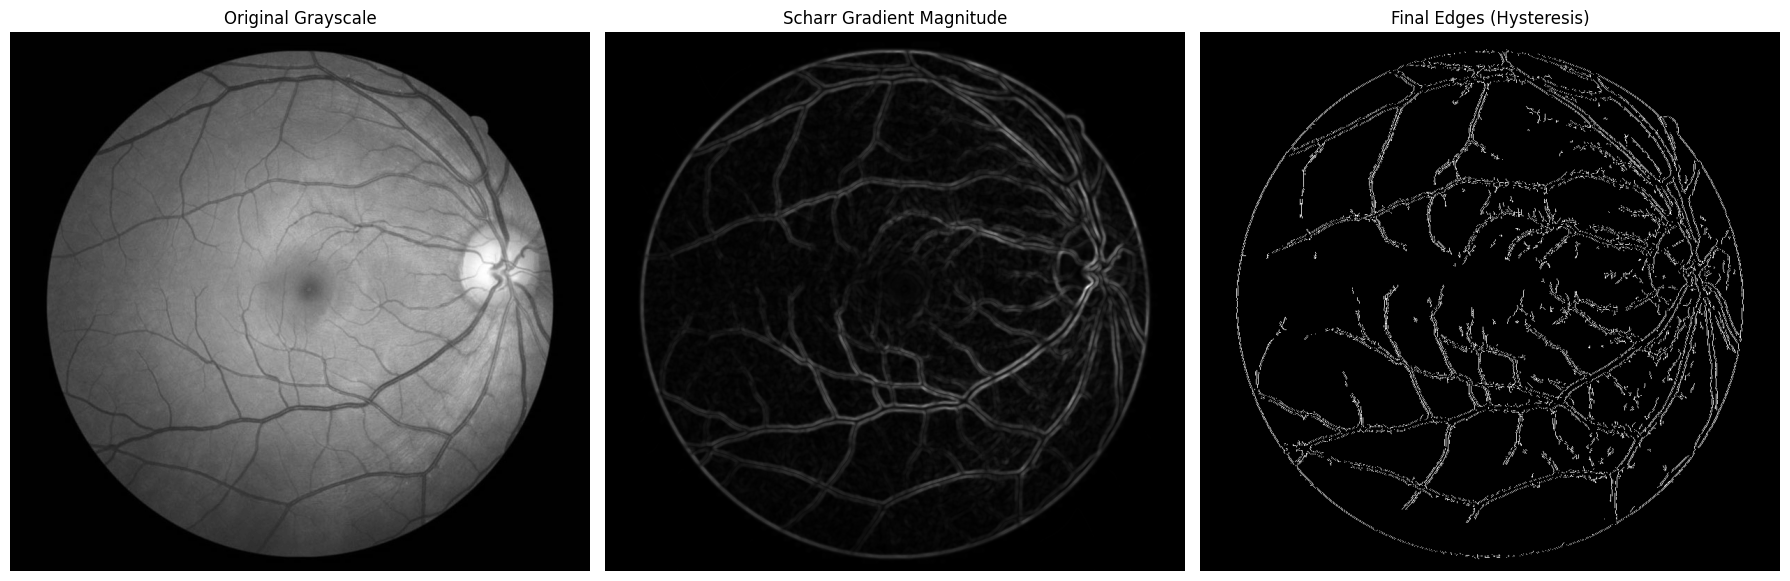

In [38]:
# 2. Run Scharr + Hysteresis Edge Detection
edges, I_kx, I_ky, I_kxx, I_kyy, I_kxy, combined_mag, orientation = scharr_edge_detection_hysteresis(
    filtered_np,
    low_ratio=0.07,  # Adjust these for your use-case
    high_ratio=0.1
)

combined = (np.abs(I_kx) + np.abs(I_ky) + np.abs(I_kxx) + np.abs(I_kyy) + np.abs(I_kxy)) / 5.0

# 3. Visualization
# Display the NMS magnitude (for reference) and the final edges
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# a) Original
axs[0].imshow(gray_img, cmap='gray')
axs[0].set_title("Original Grayscale")
axs[0].axis('off')

# b) Gradient Magnitude
axs[1].imshow(combined, cmap='gray')
axs[1].set_title("Scharr Gradient Magnitude")
axs[1].axis('off')

# c) Final Edges (hysteresis)
axs[2].imshow(edges, cmap='gray')
axs[2].set_title("Final Edges (Hysteresis)")
axs[2].axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(830.5), np.float64(771.5), np.float64(-0.5))

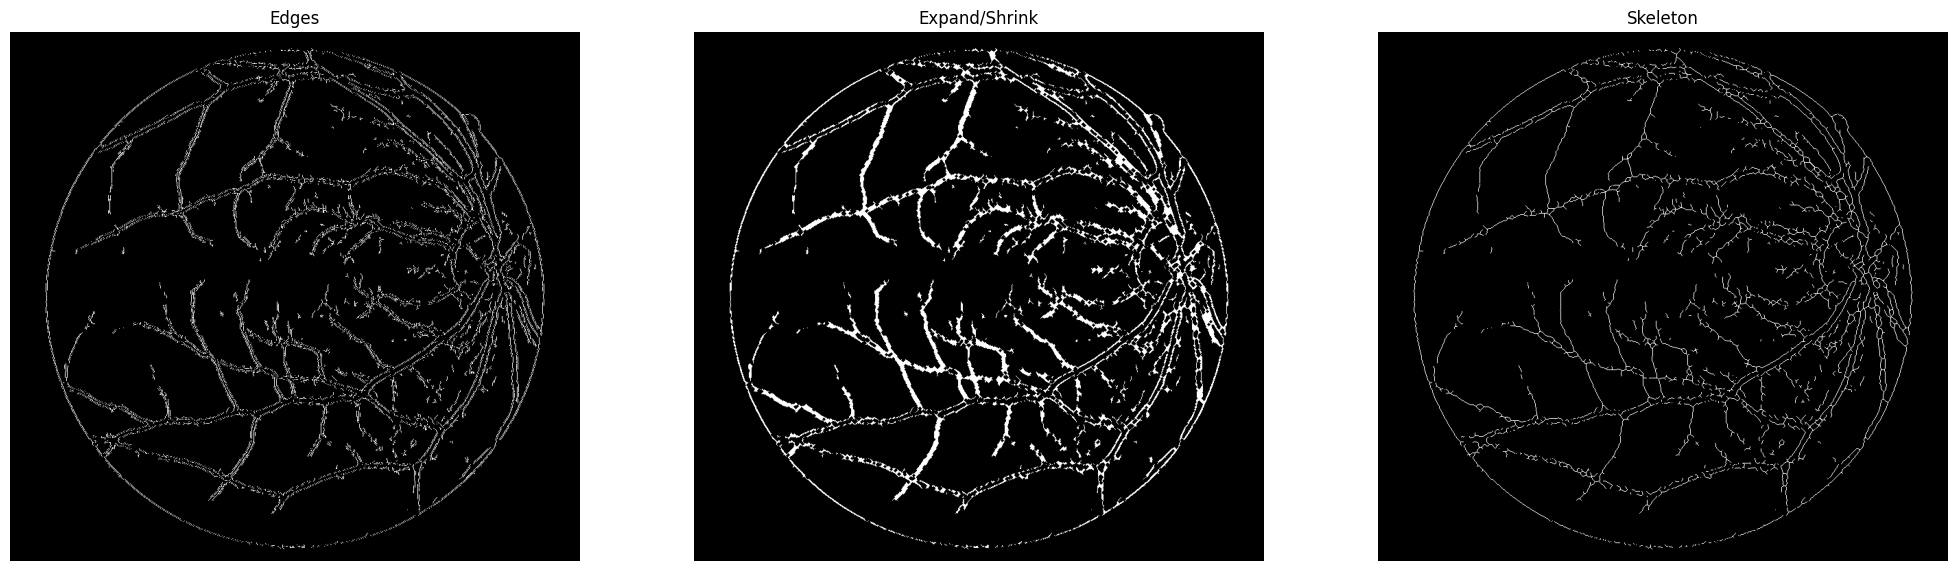

In [39]:
# Assume 'zero_crossing' is your binary image after zero-crossing detection
selem = morphology.disk(2)  # Small structuring element

# Expand the image (dilation)
expanded = morphology.binary_dilation(edges, selem)

# Shrink the image (erosion)
shrunk = morphology.binary_erosion(expanded, selem)

skeleton = morphology.skeletonize(shrunk)

# Compare original and filtered
plt.figure(figsize=(25, 20))
plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(shrunk, cmap='gray')
plt.title('Expand/Shrink')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton')
plt.axis("off")

In [40]:
def skeleton_to_graph(skeleton):
    G = nx.Graph()  # Create an empty graph
    rows, cols = np.where(skeleton > 0)  # Look for all the white pixels in the Image and extract their coordinates
    for y, x in zip(rows, cols):
        G.add_node((y, x))  # Add a node to these extracted coordinates
    for y, x in zip(rows, cols):
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:  # Check in all 8 directions for neighbouring white pixels
            neighbor = (y + dy, x + dx)  # Calculate the new position of this neighbouring pixel
            if neighbor in G.nodes:  # Check if this neighbour is white or black
                G.add_edge((y, x), neighbor)  # If it is white connect the nodes and make it an edge (Line)
    return G

def graph_based_analysis(skeleton_image):
    # Build the graph from the skeleton
    graph = skeleton_to_graph(skeleton_image > 0)

    # Initialize lists to store endpoints and bifurcation points
    endpoints_graph = []
    bifurcations_graph = []

    # Iterate through each node in the graph
    for node in graph.nodes:
    # Get the list of neighbors for the current node
        neighbors = list(graph.neighbors(node))

        # If the node has exactly one neighbor, it is an endpoint
        if len(neighbors) == 1:
            endpoints_graph.append(node)

        # If the node has three or more neighbors, it is a bifurcation point
        elif len(neighbors) >= 3:
            bifurcations_graph.append(node)

    # Store the Coordinates as numpy array
    endpoint_coords_graph = np.array(endpoints_graph)
    bifurcation_coords_graph = np.array(bifurcations_graph)

    return endpoint_coords_graph, bifurcation_coords_graph

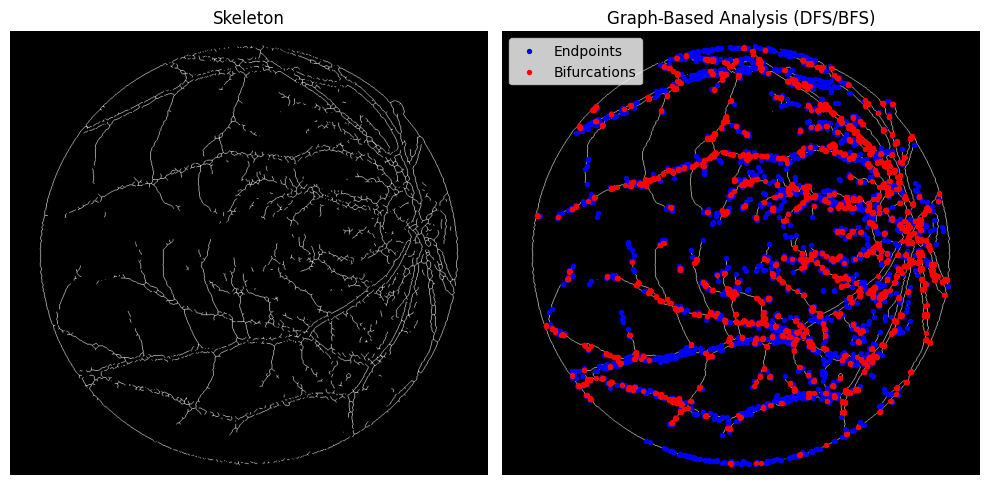

In [41]:
# Perform graph-based analysis
endpoint_coords_graph, bifurcation_coords_graph = graph_based_analysis(skeleton)

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original skeleton image
axes[0].imshow(skeleton, cmap='gray')
axes[0].set_title("Skeleton")
axes[0].axis('off')

# Plot the skeleton with endpoints and bifurcations overlaid
axes[1].imshow(skeleton, cmap='gray')
if len(endpoint_coords_graph) > 0:
    axes[1].scatter(endpoint_coords_graph[:, 1], endpoint_coords_graph[:, 0], color='blue', label='Endpoints', s=8)
if len(bifurcation_coords_graph) > 0:
    axes[1].scatter(bifurcation_coords_graph[:, 1], bifurcation_coords_graph[:, 0], color='red', label='Bifurcations', s=8)
axes[1].set_title("Graph-Based Analysis (DFS/BFS)")
axes[1].legend()
axes[1].axis('off')

plt.tight_layout()
plt.show()

Optic disc detected at: (700, 338) with radius: 57


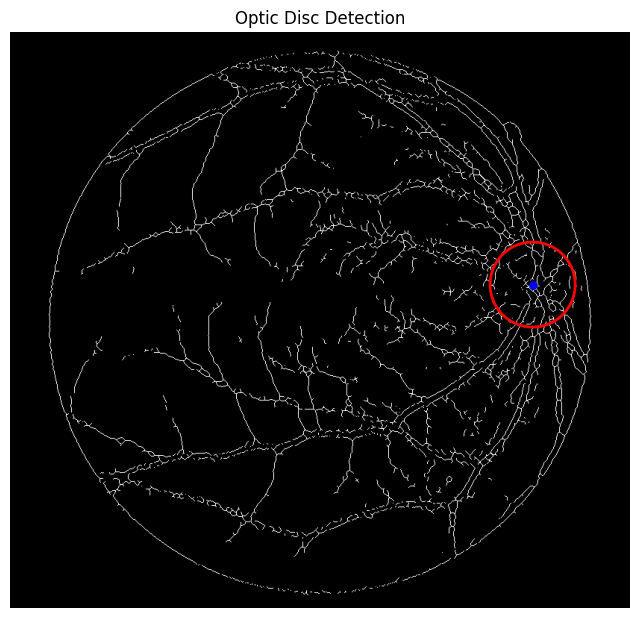

In [42]:
# Optic disc detection using Hough transform.
def detect_optic_nerve_center(image):

    # Define a range for expected optic disc radii
    hough_radii = np.arange(55, 100, 2)

    # Compute the Hough transform accumulator for circles
    hough_res = transform.hough_circle(image, hough_radii)

    # Extract the most prominent circle (i.e., the peak in the accumulator)
    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,
                                                         total_num_peaks=1)
    if len(cx) > 0:
        center = (cx[0], cy[0])
        radius = radii[0]
        print(f"Optic disc detected at: {int(center[0]), int(center[1])} with radius: {int(radius)}")

        # Visualize the result
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image, cmap='gray')
        circ = plt.Circle(center, radius, color='red', fill=False, linewidth=2)
        ax.add_patch(circ)
        ax.plot(center[0], center[1], 'bo', markersize=5)  # mark center
        ax.set_title("Optic Disc Detection")
        ax.axis('off')
        plt.show()
        return center
    else:
        print("No optic disc detected.")
        return None

center = detect_optic_nerve_center(skeleton)